<a href="https://colab.research.google.com/github/zi0-hand/policing-big-data-competition/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. 필요 라이브러리 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import io
from functools import reduce


from dataprep.eda import plot, plot_correlation, plot_missing, plot_diff

import folium
from folium import Choropleth
import plotly.express as px
import geopandas as gpd
import json
from folium import plugins

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor
#from catboost import CatBoostRegressor, Pool
#from ngboost import NGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [ ]:
pip install haversine

In [ ]:
pip install geopandas

In [ ]:
pip install dataprep

# **2. 데이터 전처리**

## **2.1 기존 변수 통합**

In [ ]:
def kp_data_preprocessing(df):
  df_road = df[(df["EVT_CL_CD"]>=400) & (df["EVT_CL_CD"]<500)]#교통사고 데이터만 분류
  df_road = df_road.dropna(axis = 0, how = "any", subset = ["HPPN_X", "HPPN_Y"])#위치데이터 사용예정이기에 결측치 제거
  df_road = df_road[(df_road["NPA_CL"]==19)|(df_road["NPA_CL"]==31)|(df_road["NPA_CL"]==13)]#대상 지역 선정
  df_road["date_time"] = pd.to_datetime(df_road["RECV_CPLT_DM"], format = "%y/%m/%d %H:%M:%S.000000000")#날짜형식으로 변경
  df_road = df_road.drop("RECV_CPLT_DM", axis = 1)#필요없는 열 제거
  df_road["HPPN_ADDR"] = df_road["HPPN_PNU_ADDR"]#파일 병합을 위한 열 제목 통일
  df_road = df_road.drop("HPPN_PNU_ADDR", axis = 1)#필요없는 열 제거(주소)
  df_road = df_road.drop("RECV_DEPT_NM", axis = 1)#필요없는 열 제거(청 이름)
  df_road["RPTER_SEX"] = df_road["RPTER_SEX"].astype("int")#파일 병합을 위한 변수타입 설정
  df_road["RPTER_SEX"] = df_road["RPTER_SEX"].astype("object")#파일 병합을 위한 변수타입 설정
  return df_road

def npa_data_preprocessing(df):

  def change(x):#시간 형식 부여를 위해 apply 할 함수
    if len(x) == 1:
      return "00000"+x
    elif len(x) == 2:
      return "0000"+x
    elif len(x) == 3:
      return "000"+x
    elif len(x) == 4:
      return "00"+x
    elif len(x) == 5:
      return "0"+x
    else:
      return x
  
  df_road = df[(df["EVT_CL_CD"]>=400) & (df["EVT_CL_CD"]<500)]#교통사고 데이터만 분류
  df_road = df_road.dropna(axis = 0, how = "any", subset = ["HPPN_X", "HPPN_Y"])#위치데이터 사용예정이기에 결측치 제거
  df_road = df_road[(df_road["NPA_CL"]==19)|(df_road["NPA_CL"]==31)|(df_road["NPA_CL"]==13)]#대상 지역 경찰청 선정
  df_road["RECV_CPLT_TM"] = df_road["RECV_CPLT_TM"].astype("str")#시간형식(0추가)를 위한 변수타입변경
  df_road["RECV_CPLT_TM"] = df_road["RECV_CPLT_TM"].apply(change)#시간형식을 apply 통해 처리
  df_road["date_time"] = df_road["RECV_CPLT_DT"].astype("str") + df_road["RECV_CPLT_TM"]#시간변수들 통합
  df_road["date_time"] = pd.to_datetime(df_road["date_time"], format = "%Y%m%d%H%M%S")#날짜형식으로 변경
  df_road = df_road.drop("RECV_CPLT_TM", axis = 1)#기존 시간데이터 제거
  df_road = df_road.drop("RECV_CPLT_DT", axis = 1)#기존 시간데이터 제거
  df_road["HPPN_ADDR"] = df_road["HPPN_OLD_ADDR"]#파일 병합을 위한 열 제목 통일
  df_road = df_road.drop("HPPN_OLD_ADDR", axis = 1)#필요없는 열 제거(주소)
  return df_road

def kp_npa_data_concat(kp2020_pre, kp2021_pre, npa_pre):
  df = pd.concat([kp2020_pre, kp2021_pre], ignore_index = True)
  df = pd.concat([npa_pre, df], ignore_index = True)
  df.drop_duplicates(keep = 'first', ignore_index = True)#2020년도 자료가 일부 겹칠 수도 있으니 중복시 앞선 데이터 따르도록 처리
  return df

def origin_data_process():
  df_kp20 = pd.read_csv('KP2020.csv', encoding='CP949')
  df_kp21 = pd.read_csv('KP2021.csv', encoding='CP949')
  df_npa20 = pd.read_csv('NPA2020.csv', encoding='CP949')
  df_kp20_pre = kp_data_preprocessing(df_kp20)
  df_kp21_pre = kp_data_preprocessing(df_kp21)
  df_npa20_pre = npa_data_preprocessing(df_npa20)
  df_total = kp_npa_data_concat(df_kp20_pre, df_kp21_pre, df_npa20_pre)
  return df_total

## **2.2 새로운 변수 이용하여 데이터 추가**

### 2.2.1버스정류장 수, 사고 수, 어린이집 수, 노인시설 수, 학교 수 추가

In [ ]:
def region_part_precess(data):

  df = data.copy()
  dj_part = ['동구', '중구', '서구', '유성구', '대덕구']
  cn_part = ['천안시', '공주시', '보령시', '아산시', '서산시', '논산시', '계룡시', '당진시', '금산군',
       '부여군', '서천군', '청양군', '홍성군', '예산군', '태안군']

  df['시군구명'] = ""
  
  df_sj = df[df['HPPN_ADDR'].str.contains('세종특별자치시', na=False)]
  df_sj['시도명'] = '세종특별자치시'
  #df_sj['시군구명'] = '세종특별자치시'

  df_dj = df[df['HPPN_ADDR'].str.contains('대전광역시', na=False)]
  df_dj['시도명'] = '대전광역시'
  
  df.loc[df['HPPN_ADDR'].str.contains('충남', na=False), 'HPPN_ADDR'] = '충청남도'
  df_cn = df[df['HPPN_ADDR'].str.contains('충청남도', na=False)]
  df_cn['시도명'] = '충청남도'

  for region in dj_part:
    df_dj.loc[df_dj['HPPN_ADDR'].str.contains(region, na=False), '시군구명'] = region
  
  for region in cn_part:
    df_cn.loc[df_cn['HPPN_ADDR'].str.contains(region, na=False), '시군구명'] = region

  df_total = pd.concat([df_sj, df_dj, df_cn])

  return df_total

In [ ]:
#버스정류장 수, 사고 수, 어린이집 수, 노인시설 수, 학교 수 추가
def region_tra_acc_near(traf, report, region, bus):
  # 데이터 넣는 순서 중요 : 신호등데이터, 신고데이터, 지역명, 버스데이터

  traf = traf[traf['시군구명']==region]
  report = report[report['시군구명']==region]

  df_sch = pd.read_csv('횡단보도count/학교시설.csv', encoding='utf-8')
  df_child = pd.read_csv('횡단보도count/어린이시설.csv', encoding='utf-8')
  df_old = pd.read_csv('횡단보도count/노인시설.csv', encoding='utf-8')

  df_sch = df_sch[df_sch['시군구명']==region]
  df_child = df_child[df_child['시군구명']==region]
  df_old = df_old[df_old['시군구명']==region]


  df1 = traf.reset_index(drop=True)
  df2 = report.reset_index(drop=True)
  df3 = df_sch.reset_index(drop=True)
  df4 = df_child.reset_index(drop=True)
  df5 = df_old.reset_index(drop=True)
  df6 = bus.reset_index(drop=True)

  df1['acc_cnt'] = 0
  df1['sch_cnt'] = 0
  df1['child_cnt'] = 0
  df1['old_cnt'] = 0
  df1['bus_cnt'] = 0

  df_acc_report = pd.DataFrame()

  for i in range(df1.shape[0]):

    num = 0
    center = (df1['위도'][i], df1['경도'][i])

    for j in range(df2.shape[0]):
      happen = (df2['HPPN_Y'][j], df2['HPPN_X'][j])
      dist = haversine(center, happen, unit='m')

      if dist <= 50: # 반경 50미터로 설정 
        num += 1
        seri = df2.loc[j]
        seri['횡단보도관리번호'] = df1.loc[i]['횡단보도관리번호']
        df_acc_report = df_acc_report.append(seri)

    df1['acc_cnt'][i] = num
  
  for i in range(df1.shape[0]):

    num = 0
    center = (df1['위도'][i], df1['경도'][i])

    for j in range(df3.shape[0]):
      happen = (df3['위도'][j], df3['경도'][j])
      dist = haversine(center, happen, unit='m')

      if dist <= 1000: # 반경 1000미터로 설정 
        num += 1

    df1['sch_cnt'][i] = num


  for i in range(df1.shape[0]):

    num = 0
    center = (df1['위도'][i], df1['경도'][i])

    for j in range(df4.shape[0]):
      happen = (df4['위도'][j], df4['경도'][j])
      dist = haversine(center, happen, unit='m')

      if dist <= 1000: # 반경 1000미터로 설정 
        num += 1

    df1['child_cnt'][i] = num
  
  for i in range(df1.shape[0]):

    num = 0
    center = (df1['위도'][i], df1['경도'][i])

    for j in range(df5.shape[0]):
      happen = (df5['위도'][j], df5['경도'][j])
      dist = haversine(center, happen, unit='m')

      if dist <= 1000: # 반경 1000미터로 설정 
        num += 1

    df1['old_cnt'][i] = num

  for i in range(df1.shape[0]):

    num = 0
    center = (df1['위도'][i], df1['경도'][i])

    for j in range(df6.shape[0]):
      happen = (df6['위도'][j], df6['경도'][j])
      dist = haversine(center, happen, unit='m')

      if dist <= 150: # 반경 150미터로 설정 
        num += 1

    df1['bus_cnt'][i] = num

    #df_acc_report = df_acc_report.drop_duplicates()

  
  return df1, df_acc_report

In [ ]:
f = origin_data_process()
df_total = region_part_precess(df)

bus_dj = pd.read_csv('횡단보도count/dj_bus.csv', encoding='cp949')#버스변수
df_acc_cnt, df_acc_report = region_tra_acc_near(df_cross_all, df_total, '동구', bus_dj)#횡단보도 데이터에 신고수, 버스정류장 수등 추가

In [ ]:
df_acc_cnt.to_csv('횡단보도cnt 데이터 모음/df_acc_dj_jg.csv', index=False)
df_acc_report.to_csv('횡단보도cnt 데이터 모음/df_acc_report_dj_jg.csv', index=False) #추후 분석 위해 파일로 저장

### 2.2.2무인단속카메라 수 추가

In [ ]:
from haversine import haversine
def cctv_num(cctv_data, location_data):
  location_data["cctv_cnt"] = 0 
  def haversine_loc(x):
    hppn_cord = (x[0], x[1])
    def dis(x):
      loc_cord = (x[0],x[1])
      if haversine(loc_cord, hppn_cord, unit = 'm')<100:
        return x[2]+1
      else:
        return x[2]
    location_data["cctv_cnt"] = location_data[["위도", "경도", "cctv_cnt"]].apply(lambda x: dis(x), axis=1)
  cctv_data[["위도", "경도"]].apply(lambda x: haversine_loc(x), axis=1)
  return location_data

In [ ]:
df_cctv_ch = pd.read_csv("/content/drive/MyDrive/SSP_cctv_data/충청남도_천안시_무인교통단속카메라.csv", encoding='cp949')
df_cctv_ss = pd.read_csv("/content/drive/MyDrive/SSP_cctv_data/충청남도_서산시_무인교통단속카메라.csv", encoding='cp949')
df_cctv_br = pd.read_csv("/content/drive/MyDrive/SSP_cctv_data/충청남도_보령시_무인교통단속카메라.csv", encoding='cp949')
df_cctv_sc = pd.read_csv("/content/drive/MyDrive/SSP_cctv_data/충청남도_서천군_무인교통단속카메라.csv", encoding='cp949')
df_cctv_ys = pd.read_csv("/content/drive/MyDrive/SSP_cctv_data/충청남도_예산군_무인교통단속카메라.csv", encoding='cp949')
df_cctv_ta = pd.read_csv("/content/drive/MyDrive/SSP_cctv_data/충청남도_태안군_무인교통단속카메라.csv", encoding='cp949') 
df_cctv_dj = pd.read_csv("/content/drive/MyDrive/SSP_cctv_data/대전광역시_무인교통단속카메라_20221215.csv", encoding='cp949')
df_cctv_sj = pd.read_csv("/content/drive/MyDrive/SSP_cctv_data/경찰청 세종특별자치시경찰청_무인교통단속카메라_20220520.csv", encoding='cp949')
#무인단속카메라 파일 불러오기

df = pd.read_csv("/content/drive/MyDrive/SSP_Data/횡단보도_피처_count/df_cnt_all.csv", encoding='UTF-8')
#2.2.1의 데이터 불러오기

df_ch_cctv_p = cctv_num(df_cctv_ch, df_ch)
df_ss_cctv_p = cctv_num(df_cctv_ss, df_ss)
df_br_cctv_p = cctv_num(df_cctv_br, df_br)
df_ys_cctv_p = cctv_num(df_cctv_ys, df_ys)
df_sc_cctv_p = cctv_num(df_cctv_sc, df_sc)
df_ta_cctv_p = cctv_num(df_cctv_ta, df_ta)
df_dj_cctv_p = cctv_num(df_cctv_dj, df_dj)
df_sj_cctv_p = cctv_num(df_cctv_sj, df_sj)
#변수별 데이터 추가

df_cctv_cnt_can_final = df_ch_cctv_p
for i in df_files_list:
  df_cctv_cnt_can_final = pd.concat([df_cctv_cnt_can_final,i], ignore_index=True)
#최종파일로 병합
df_cctv_cnt_can_final.to_csv('/content/drive/MyDrive/SSP_cctv_data/df_cctv_contain.csv', encoding = "cp949")
#파일로 내보내기

### **2.2.3 아파트 데이터 추가**

In [ ]:
def apt_process():
  df_apt = pd.read_excel('아파트/20230201_단지_기본정보.xlsx', header=1)
  df_apt = df_apt.iloc[:, [0,1,2,3,7,8,13]]
  df_apt = df_apt.fillna('')
  df_apt = df_apt.replace('천안서북구', '천안시')
  df_apt = df_apt.replace('천안동남구', '천안시')
  df_apt['큰주소'] = df_apt['시도'] + ' ' + df_apt['시군구'] + ' ' + df_apt['읍면'] + ' ' + df_apt['동리']
  df_apt['큰주소'] = df_apt['큰주소'].str.replace('   ', ' ')
  df_apt['큰주소'] = df_apt['큰주소'].str.replace('  ', ' ')
  df_sj = df_apt[df_apt['시도']=='세종특별자치시']
  df_dj = df_apt[df_apt['시도']=='대전광역시']
  df_cn = df_apt[df_apt['시도']=='충청남도']
  df_total = pd.concat([df_sj, df_dj, df_cn])
  return df_total, df_sj, df_dj, df_cn

In [ ]:
apar_total, apar_sj, apar_dj, apar_cn = apt_process()

In [ ]:
def apar_cnt(traf, apar):# 횡단보도와 아파트 데이터 결합

  df1 = traf.reset_index(drop=True)
  df2 = apar.reset_index(drop=True)

  df1['도로명'] = df1['도로명'].str.replace(' ','')
  df2['도로명주소'] = df2['도로명주소'].str.replace(' ','')
  df1['소재지지번주소'] = df1['소재지지번주소'].str.replace(' ','')
  df2['큰주소'] = df2['큰주소'].str.replace(' ','')

  df1['apar_rd_cnt'] = 0
  df1['apar_rd_fam'] = 0
  df1['apar_ad_cnt'] = 0
  df1['apar_ad_fam'] = 0



  for i in range(df1.shape[0]):
  
    ad_num = 0
    ad_fam_num = 0
    rd_num = 0
    rd_fam_num = 0
  
    for j in range(df2.shape[0]):

      if df1['도로명'][i] in df2['도로명주소'][j]:
        rd_num += 1
        rd_fam_num += df2['세대수'][j]

      if df2['큰주소'][j] in df1['소재지지번주소'][i]:
        ad_num += 1
        ad_fam_num += df2['세대수'][j]      

    df1['apar_rd_cnt'][i] = rd_num
    df1['apar_rd_fam'][i] = rd_fam_num
    df1['apar_ad_cnt'][i] = ad_num
    df1['apar_ad_fam'][i] = ad_fam_num
  
  return df1

In [ ]:
def apar_cnt_both(data):#아파트 데이터 도로명, 지번 결합
  df = data.copy()
  df["apar_count_both"] = 0
  df["apar_fam_both"] = 0
  df.loc[((df["apar_rd_fam"]!=0)&(df["apar_ad_fam"]!=0))&(df["apar_rd_fam"]>=df["apar_ad_fam"]), "apar_fam_both"] = df["apar_rd_fam"]
  df.loc[((df["apar_rd_fam"]!=0)&(df["apar_ad_fam"]!=0))&(df["apar_rd_fam"]<df["apar_ad_fam"]), "apar_fam_both"] = df["apar_ad_fam"]
  df.loc[(df["apar_rd_fam"]==0)&(df["apar_ad_fam"]!=0), "apar_fam_both"] = df["apar_ad_fam"]
  df.loc[(df["apar_rd_fam"]!=0)&(df["apar_ad_fam"]==0), "apar_fam_both"] = df["apar_rd_fam"]
  df.loc[((df["apar_rd_cnt"]!=0)&(df["apar_ad_cnt"]!=0))&(df["apar_rd_cnt"]>=df["apar_ad_cnt"]), "apar_count_both"] = df["apar_rd_cnt"]
  df.loc[((df["apar_rd_cnt"]!=0)&(df["apar_ad_cnt"]!=0))&(df["apar_rd_cnt"]<df["apar_ad_cnt"]), "apar_count_both"] = df["apar_ad_cnt"]
  df.loc[(df["apar_rd_cnt"]==0)&(df["apar_ad_cnt"]!=0), "apar_count_both"] = df["apar_ad_cnt"]
  df.loc[(df["apar_rd_cnt"]!=0)&(df["apar_ad_cnt"]==0), "apar_count_both"] = df["apar_rd_cnt"]
  df = df.drop(['apar_rd_cnt', 'apar_rd_fam', 'apar_ad_cnt', 'apar_ad_fam'], axis=1)
  return df

### **2.2.4 행정구역별 연령별 인구데이터 추가** 

In [ ]:
def popu_process():

  popu = pd.read_csv('전국_연령별인구현황.csv', encoding='cp949')

  popu['총인구'] = popu['2023년01월_계_총인구수']
  popu['아동수'] = popu['2023년01월_계_0~9세']
  popu['청소년수'] = popu['2023년01월_계_10~19세']
  popu['청년수'] = popu['2023년01월_계_20~29세']
  popu['중년수'] = popu['2023년01월_계_30~39세'] + popu['2023년01월_계_40~49세'] 
  popu['장년수'] = popu['2023년01월_계_50~59세'] + popu['2023년01월_계_60~69세']
  popu['노년수'] = popu['2023년01월_계_70~79세'] + popu['2023년01월_계_80~89세'] + popu['2023년01월_계_90~99세'] + popu['2023년01월_계_100세 이상']

  list = popu["행정구역"].str.split(" ")
  popu["시도명"] = list.str.get(0)
  popu["시군구명"] = list.str.get(1)

  popu = popu[['행정구역','시도명','시군구명','총인구','아동수','청소년수','청년수','중년수','장년수','노년수']]
  #popu.drop_duplicates(inplace=True)
  popu.drop([72,85,177, 179, 180], axis=0, inplace=True)

  popu = popu[(popu['시도명']=='세종특별자치시') | (popu['시도명']=='대전광역시') | (popu['시도명']=='충청남도')]
  popu_sj =  popu[popu['시도명']=='세종특별자치시']
  popu_dj =  popu[popu['시도명']=='대전광역시']
  popu_cn =  popu[popu['시도명']=='충청남도']


  return popu, popu_sj, popu_dj, popu_cn

popu_all, popu_sj, popu_dj, popu_cn = popu_process()

### **2.2.5 행정구역별 초중등학교 데이터 추가** 

In [ ]:
def sch_preprocessing():
  df_sch = pd.read_csv('어린이청소년노인/전국초중등학교위치표준데이터.csv', encoding='cp949')
  df = df_sch
  df = df[['학교급구분','소재지지번주소','위도','경도']]
  df_sch_sj = df[df['소재지지번주소'].str.contains('세종특별자치시', na=False)]
  df_sch_dj = df[df['소재지지번주소'].str.contains('대전광역시', na=False)]
  df_sch_cn = df[df['소재지지번주소'].str.contains('충청남도', na=False)]
  return df_sch_sj, df_sch_dj, df_sch_cn

df_sch_sj, df_sch_dj, df_sch_cn = sch_preprocessing()
df_sch = pd.read_csv('어린이청소년노인/전국초중등학교위치표준데이터.csv', encoding='cp949')

def sch_region_part_precess(data):

  df = data.copy()
  dj_part = ['동구', '중구', '서구', '유성구', '대덕구']
  cn_part = ['천안시', '공주시', '보령시', '아산시', '서산시', '논산시', '계룡시', '당진시', '금산군',
       '부여군', '서천군', '청양군', '홍성군', '예산군', '태안군']

  df['시군구명'] = ""
  
  df_sj = df[df['소재지지번주소'].str.contains('세종특별자치시', na=False)]
  df_sj['시도명'] = '세종특별자치시'
  #df_sj['시군구명'] = '세종특별자치시'

  df_dj = df[df['소재지지번주소'].str.contains('대전광역시', na=False)]
  df_dj['시도명'] = '대전광역시'
  
  df.loc[df['소재지지번주소'].str.contains('충남', na=False), '소재지지번주소'] = '충청남도'
  df_cn = df[df['소재지지번주소'].str.contains('충청남도', na=False)]
  df_cn['시도명'] = '충청남도'

  for region in dj_part:
    df_dj.loc[df_dj['소재지지번주소'].str.contains(region, na=False), '시군구명'] = region
  
  for region in cn_part:
    df_cn.loc[df_cn['소재지지번주소'].str.contains(region, na=False), '시군구명'] = region

  df_total = pd.concat([df_sj, df_dj, df_cn])

  return df_total, df_sj, df_dj, df_cn

df_total, df_sj, df_dj, df_cn = sch_region_part_precess(df_sch)

df_sch = df_total.copy()

def repo_cnt(data):
  df = data.groupby(['시도명', '시군구명']).count()['학교명'].reset_index().rename(columns={'학교명':'학교수'})
  return df

df_sch_cnt = repo_cnt(df_sch)

# **3. 데이터 시각화(그래프)**
- 사용 데이터 : '행정구역별 피처.csv'

### 3.1 필요데이터 불러오기

In [ ]:
df_expect_cross_acc = pd.read_csv('/content/drive/MyDrive/MR_Study_at/SSP_Data/EDA를위한/횡단보도사건제외신고_all.csv', encoding= 'UTF-8') #횡단보도 외 교통사고 데이터
df_acc_report = pd.read_csv('/content/drive/MyDrive/MR_Study_at/SSP_Data/EDA를위한/df_acc_report_중복제거_all.csv', encoding= 'UTF-8') #횡단보도 교통사고 중 횡단보도고유번호 제외+중복 제거
df_acc_report_crossnum = pd.read_csv('/content/drive/MyDrive/MR_Study_at/SSP_Data/EDA를위한/df_acc_report_all.csv', encoding= 'UTF-8') #횡단보도 교통사고 중 횡단보도고유번호 포함+중복 포함
df_acc = pd.read_csv('/content/drive/MyDrive/MR_Study_at/SSP_Data/EDA를위한/df_acc.csv', encoding= 'UTF-8') #횡단보도 교통사고 중 count 포함

df_acc['시군구명'] = df_acc['시군구명'].str.replace("없음", "세종시")
df_expect_cross_acc['NPA_CL'] = df_expect_cross_acc['NPA_CL'].apply(str)
df_expect_cross_acc['NPA_CL'] = df_expect_cross_acc['NPA_CL'].str.replace("19.0", "충남청")
df_expect_cross_acc['NPA_CL'] = df_expect_cross_acc['NPA_CL'].str.replace("13.0", "대전청")
df_expect_cross_acc['NPA_CL'] = df_expect_cross_acc['NPA_CL'].str.replace("31.0", "세종청")
df_expect_cross_acc['EVT_CL_CD'] = df_expect_cross_acc['EVT_CL_CD'].apply(str)
df_expect_cross_acc['EVT_CL_CD'] = df_expect_cross_acc['EVT_CL_CD'].str.replace("401.0", "교통사고")
df_expect_cross_acc['EVT_CL_CD'] = df_expect_cross_acc['EVT_CL_CD'].str.replace("406.0", "음주운전")
df_expect_cross_acc['EVT_CL_CD'] = df_expect_cross_acc['EVT_CL_CD'].str.replace("402.0", "교통불편")
df_expect_cross_acc['EVT_CL_CD'] = df_expect_cross_acc['EVT_CL_CD'].str.replace("403.0", "교통위반")
df_expect_cross_acc['EVT_CL_CD'] = df_expect_cross_acc['EVT_CL_CD'].str.replace("405.0", "인피도주")
df_expect_cross_acc['EVT_CL_CD'] = df_expect_cross_acc['EVT_CL_CD'].str.replace("404.0", "사망.대형사고")
df_acc_report['NPA_CL'] = df_acc_report['NPA_CL'].apply(str)
df_acc_report['NPA_CL'] = df_acc_report['NPA_CL'].str.replace("19.0", "충남청")
df_acc_report['NPA_CL'] = df_acc_report['NPA_CL'].str.replace("13.0", "대전청")
df_acc_report['NPA_CL'] = df_acc_report['NPA_CL'].str.replace("31.0", "세종청")
df_acc_report['EVT_CL_CD'] = df_acc_report['EVT_CL_CD'].apply(str)
df_acc_report['EVT_CL_CD'] = df_acc_report['EVT_CL_CD'].str.replace("401.0", "교통사고")
df_acc_report['EVT_CL_CD'] = df_acc_report['EVT_CL_CD'].str.replace("406.0", "음주운전")
df_acc_report['EVT_CL_CD'] = df_acc_report['EVT_CL_CD'].str.replace("402.0", "교통불편")
df_acc_report['EVT_CL_CD'] = df_acc_report['EVT_CL_CD'].str.replace("403.0", "교통위반")
df_acc_report['EVT_CL_CD'] = df_acc_report['EVT_CL_CD'].str.replace("405.0", "인피도주")
df_acc_report['EVT_CL_CD'] = df_acc_report['EVT_CL_CD'].str.replace("404.0", "사망.대형사고")

### 3.2 데이터 그래프 작성

#### **3.2.1 사고 파일 분석**

In [ ]:
plot_missing(df_acc)

In [ ]:
plot(df_acc)

In [ ]:
plot_correlation(df_acc)

####**3.2.2 사고발생건수**

In [ ]:
plot(df_acc, "시도명","acc_cnt")

In [ ]:
plot(df_acc, "시군구명","acc_cnt")

In [ ]:
plot(df_acc, "도로명","acc_cnt")

####**3.2.3 학교수(sch_cnt)**

In [ ]:
plot(df_acc, "시도명","sch_cnt")

In [ ]:
plot(df_acc, "시군구명","sch_cnt")

In [ ]:
plot(df_acc, "도로명","sch_cnt")

#### **3.2.4 어린이시설수(child_cnt)**

In [ ]:
plot(df_acc, "시도명","child_cnt")

In [ ]:
plot(df_acc, "시군구명","child_cnt")

In [ ]:
plot(df_acc, "도로명","child_cnt")

#### **3.2.5 노인장애인시설수(old_cnt)**

In [ ]:
plot(df_acc, "시도명","old_cnt")

In [ ]:
plot(df_acc, "시군구명","old_cnt")

In [ ]:
plot(df_acc, "도로명","old_cnt")

#### **3.2.6 버스정류장수(bus_cnt)**

In [ ]:
plot(df_acc, "시도명","bus_cnt")

In [ ]:
plot(df_acc, "시군구명","bus_cnt")

In [ ]:
plot(df_acc, "도로명","bus_cnt")

#### **3.2.7 횡단보도사건제외신고_all**

In [ ]:
plot_missing(df_expect_cross_acc)

In [ ]:
plot(df_expect_cross_acc)

In [ ]:
plot_correlation(df_expect_cross_acc)

#### **3.2.8 df_acc_report_중복제거_all**

In [ ]:
plot_missing(df_acc_report)

In [ ]:
plot(df_acc_report)

In [ ]:
plot_correlation(df_acc_report)

#### **3.2.9 df_acc_report_all**

In [ ]:
df_acc_report_crossnum.describe()

In [ ]:
plot_missing(df_acc_report_crossnum)

In [ ]:
plot(df_acc_report_crossnum)

In [ ]:
plot_correlation(df_acc_report_crossnum)

#### **3.2.10 횡단보도 외 교통사고 vs 횡단보도 사고**

##### **3.2.10.1 중복제거**

In [ ]:
plot_diff([df_expect_cross_acc, df_acc_report])

##### **3.2.10.2 중복포함**

In [ ]:
plot_diff([df_expect_cross_acc, df_acc_report_crossnum])

#### **3.2.11 중복데이터 확인**

In [ ]:
plot_diff([df_acc_report, df_acc_report_crossnum])

# **4. 데이터 시각화(매핑)**
- 사용 데이터 : '행정구역별 피처.csv'

## **4.1 shp데이터 불러오기**

In [ ]:
sigun_geo = gpd.read_file("/content/drive/MyDrive/SSP_Data/sig_fn.zip.geojson", encoding = 'cp949')

## **4.2 지형 데이터 수정, 매핑할 파일 불러오기**

In [ ]:
df_expect_cross_acc = pd.read_csv('/content/drive/MyDrive/SSP_Data/EDA를위한/횡단보도사건제외신고_all.csv', encoding= 'UTF-8') #횡단보도 외 교통사고 데이터
df_acc_report = pd.read_csv('/content/drive/MyDrive/SSP_Data/EDA를위한/df_acc_report_중복제거_all.csv', encoding= 'UTF-8') #횡단보도 교통사고 중 횡단보도고유번호 제외+중복 제거
df_acc_report_crossnum = pd.read_csv('/content/drive/MyDrive/SSP_Data/EDA를위한/df_acc_report_all.csv', encoding= 'UTF-8') #횡단보도 교통사고 중 횡단보도고유번호 포함+중복 포함
df_acc = pd.read_csv('/content/drive/MyDrive/SSP_Data/EDA를위한/df_acc.csv', encoding= 'UTF-8') #횡단보도 교통사고 중 count 포함
sch_data = pd.read_csv("/content/drive/MyDrive/SSP_Data/어린이청소년노인/전국초중등학교위치표준데이터.csv", encoding = "cp949")
df2 = pd.read_csv('/content/drive/MyDrive/SSP_Data/clustering_result.csv', encoding = "UTF-8")

df_clus = df_clus[df_clus['predict']==2]
list = sch_data["소재지지번주소"].str.split(" ")
sch_data.loc[sch_data["시도명"]=="세종특별자치시", "시군구명"] = "세종특별자치시"
sch_data["시도명"] = list.str.get(0)
sch_data["시군구명"] = list.str.get(1)
sigun_geo.loc[sigun_geo["SIG_CD"]=="36110", "SIG_CD"] = "36000"
df_geo = sigun_geo[sigun_geo['SIG_CD'].str.startswith(('30', '36', '44'))]
df_acc_report.loc[df_acc_report["시도명"]=="세종특별자치시", "시군구명"] = "세종특별자치시"

## **4.3 지도 그리기**

In [ ]:
def df_map(sigun_geo):
  borderstyle={
  'color': '#000000',
  'weight': 1,
  'fillColor': '#FFFFFF',
  'fillOpacit': 0
  }#경계선 스타일 설정
  df_m = folium.Map(location = [36.50000, 127.50000], zoom_start = 10)#기본 맵 생성
  df_geo = sigun_geo[sigun_geo['SIG_CD'].str.startswith(('30', '36', '44'))]# 충남, 대전 세종 경계 데이터만을 geojson파일에서 뽑아내기
  folium.GeoJson(df_geo,name='json_data', style_function = lambda x:borderstyle).add_to(df_m)#지도에 경계 데이터 geojson파일 추가
  return df_m

In [ ]:
def city_Choropleth_creator(test, city_data, map, variable, name_of_Choropleth, name_of_legend):#지리정보, 분석파일, 지도, 분석변수
  folium.Choropleth(
      geo_data=test,
      name= str(name_of_Choropleth),
      data= city_data,
      columns=["시군구명", str(variable)],
       key_on='feature.properties.SIG_KOR_NM',
      fill_color='YlOrRd',
      fill_opacity=0.5,
      line_opacity=0.3,
    color = 'gray',
      legend_name = str(name_of_legend)
  ).add_to(map)
  return map

In [ ]:
from folium.plugins import MarkerCluster
def map_marker_cluster(map):
  marker_cluster = MarkerCluster().add_to(map)
  return marker_cluster

In [ ]:
from folium import Marker
def make_marker(map, data):
  for index, row in data.iterrows():
      folium.CircleMarker(location = [row['위도'], row['경도']],
                          radius=1,
                          color='#50bcdf',
                          fill_color='#50bcdf',
                          fill_opacity= 1,
                          tooltip = str(row["학교명"])
                          ).add_to(map)
  return map

In [ ]:
def make_marker_cluster(map, data):
  for index, row in data.iterrows():
      folium.CircleMarker(location = [row['위도'], row['경도']],
                          radius=1,
                          color='#50bcdf',
                          fill_color='#50bcdf',
                          fill_opacity= 1,
                          ).add_to(map)
  return map

### **4.3.1 횡단보도 사고 건수**

In [ ]:
acc_cnt_map = df_map(df_geo)

In [ ]:
folium.Choropleth(
    geo_data=test,
    name='신고 사건 수',
    data=df_acc_map_data,
    columns=["시군구명", "신고건수"],
    key_on='feature.properties.SIG_KOR_NM',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.3,
    color = 'gray',
    legend_name = '횡단보도 발생 교통사고수'
).add_to(acc_cnt_map)

In [ ]:
acc_cnt_map

### **4.3.2 사고발생건수(충남 대전 세종 전체)**

In [ ]:
acc_map = df_map(sigun_geo)

In [ ]:
acc_map = city_Choropleth_creator(test, loc_data_code, acc_map, "신고건수", "사고발생수", "사고 발생수")#지리정보, 분석파일, 지도, 분석변수

In [ ]:
acc_map

### **4.3.3 충남, 대전 세종 인구 1명당 사고 발생 건수**

In [ ]:
loc_data_code["인구 대비 신고수"] = loc_data_code["신고건수"]/loc_data_code["총인구"]

In [ ]:
acc_per_popul = df_map(sigun_geo)

In [ ]:
folium.Choropleth(
    geo_data=test,
    name='인구 대비 신고수',
    data=loc_data_code,
    columns=["시군구명", "인구 대비 신고수"],
    key_on='feature.properties.SIG_KOR_NM',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.3,
    color = 'gray',
    legend_name = '시민 1명당 신고수'
).add_to(acc_per_popul)

In [ ]:
acc_per_popul

### **4.3.4 충남, 대전 세종 인구 1명당 횡단보도 사고 발생 건수**

In [ ]:
cw_acc_per_popul = df_map(sigun_geo)

In [ ]:
loc_data_df["인구 대비 횡단보도 신고수"] = loc_data_df["횡단신고"]/loc_data_code["총인구"]

In [ ]:
cw_acc_per_popul = df_map(sigun_geo)

In [ ]:
cw_acc_per_popul = city_Choropleth_creator(test, loc_data_df, cw_acc_per_popul, "인구 대비 횡단보도 신고수", "인구 대비 횡단보도 신고수", "1인당 횡단보도 사고수")

In [ ]:
cw_acc_per_popul

### **4.3.5 아동, 청소년 한명당 횡단보도 사고**

In [ ]:
loc_data_df["어린이, 청소년인구 대비 횡단보도 신고수"] = loc_data_df["횡단신고"]/(loc_data_code["아동수"] + loc_data_code["청소년수"])

In [ ]:
cw_acc_per_ch = df_map(sigun_geo)

In [ ]:
cw_acc_per_ch = city_Choropleth_creator(test, loc_data_df, cw_acc_per_ch, "어린이, 청소년인구 대비 횡단보도 신고수", "어린이, 청소년인구 대비 횡단보도 신고수", "어린이, 청소년 1인당 횡단보도 사고수")

In [ ]:
cw_acc_per_ch

### **4.3.6 노인 1명당 횡단보도 사고 발생 건수**

In [ ]:
loc_data_df["노인 인구 대비 횡단보도 신고수"] = loc_data_df["횡단신고"]/loc_data_code["노년수"]

In [ ]:
cw_acc_per_old = df_map(sigun_geo)

In [ ]:
cw_acc_per_old = city_Choropleth_creator(test, loc_data_df, cw_acc_per_old, "노인 인구 대비 횡단보도 신고수", "노인 1명당 횡단보도 신고수", "노인 1인당 횡단보도 사고수")

In [ ]:
cw_acc_per_old

### **4.3.7 노인인구 비율**

In [ ]:
loc_data_df["노인 인구 밀도"] = loc_data_df["노년수"]/loc_data_df["총인구"]

In [ ]:
old_per = df_map(sigun_geo)

In [ ]:
old_per = city_Choropleth_creator(test, loc_data_df, old_per, "노인 인구 밀도", "노인 인구 밀도 지도", "노인인구 비율")

In [ ]:
old_per

### **4.3.8 아동, 청소년 인구 비율**

In [ ]:
loc_data["아동, 청소년 인구 밀도"] = (loc_data["아동수"] + loc_data["청소년수"])/loc_data_code["총인구"]

In [ ]:
ch_per = df_map(sigun_geo)

In [ ]:
ch_per = city_Choropleth_creator(test, loc_data, ch_per, "아동, 청소년 인구 밀도", "아동, 청소년 인구 밀도 지도", "아동, 청소년 인구 비율")

In [ ]:
ch_per

### **4.3.9 장년, 노인 인구 비율**

In [ ]:
loc_data["장년, 노인 인구 밀도"] = (loc_data["장년수"] + loc_data["노년수"])/loc_data_code["총인구"]

In [ ]:
sold_per = df_map(sigun_geo)

In [ ]:
sold_per  = city_Choropleth_creator(test, loc_data, sold_per , "장년, 노인 인구 밀도", "장년, 노인 인구 밀도 지도", "장년, 노인 인구 비율")

In [ ]:
sold_per

### **4.3.10 전체학교수**

In [ ]:
sch_map = df_map(sigun_geo)

In [ ]:
sch_map  = city_Choropleth_creator(test, loc_data, sch_map , "학교수", "학교수 밀도, 위치 지도", "학교수")

In [ ]:
sch_map

### **4.3.11 학교 마킹**

In [ ]:
sch_marker_map = df_map(sigun_geo)

In [ ]:
sch_marker_map  = city_Choropleth_creator(test, loc_data_df, sch_marker_map , "학교수", "학교수, 위치 지도", "학교수")

In [ ]:
sch_marker_map

In [ ]:
sch_marker_map = make_marker(sch_marker_map, sch_df_data)

In [ ]:
sch_marker_map

### **4.3.12 군집 내 횡단보도 마킹**

In [ ]:
cluster_map = df_map(sigun_geo)

In [ ]:
cluster_map = city_Choropleth_creator(test, df_clus_num, cluster_map, "횡단보도 수", "지역별 대상 횡단보도 수, 마커", "지역별 대상 횡단보도 수")

In [ ]:
cluster_map = make_marker_cluster(cluster_map, df_clus)

In [ ]:
cluster_map

# **5. 데이터 모델링**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import io
from functools import reduce
import os
os.chdir('/content/drive/MyDrive/MR_Study_at/SSP_Data')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-san

## **5.1 모델링 함수 정의**

In [ ]:
def apar_cnt_both(data):#전처리의 아파트 도로명, 지번 통합 함수와 동일
  df = data.copy()
  df["apar_count_both"] = 0
  df["apar_fam_both"] = 0
  df.loc[((df["apar_rd_fam"]!=0)&(df["apar_ad_fam"]!=0))&(df["apar_rd_fam"]>=df["apar_ad_fam"]), "apar_fam_both"] = df["apar_ad_fam"]
  df.loc[((df["apar_rd_fam"]!=0)&(df["apar_ad_fam"]!=0))&(df["apar_rd_fam"]<df["apar_ad_fam"]), "apar_fam_both"] = df["apar_ad_fam"]
  df.loc[(df["apar_rd_fam"]==0)&(df["apar_ad_fam"]!=0), "apar_fam_both"] = df["apar_ad_fam"]
  df.loc[(df["apar_rd_fam"]!=0)&(df["apar_ad_fam"]==0), "apar_fam_both"] = df["apar_rd_fam"]
  df.loc[((df["apar_rd_cnt"]!=0)&(df["apar_ad_cnt"]!=0))&(df["apar_rd_cnt"]>=df["apar_ad_cnt"]), "apar_count_both"] = df["apar_ad_cnt"]
  df.loc[((df["apar_rd_cnt"]!=0)&(df["apar_ad_cnt"]!=0))&(df["apar_rd_cnt"]<df["apar_ad_cnt"]), "apar_count_both"] = df["apar_ad_cnt"]
  df.loc[(df["apar_rd_cnt"]==0)&(df["apar_ad_cnt"]!=0), "apar_count_both"] = df["apar_ad_cnt"]
  df.loc[(df["apar_rd_cnt"]!=0)&(df["apar_ad_cnt"]==0), "apar_count_both"] = df["apar_rd_cnt"]
  df = df.drop(['apar_rd_cnt', 'apar_rd_fam', 'apar_ad_cnt', 'apar_ad_fam'], axis=1)
  return df

In [ ]:
from sklearn.preprocessing import LabelEncoder # 라벨 인코딩 함수

def label_encoding(data):

  df = data.copy()
  df_ty = df.apply(lambda x: x.dtype)
  df_cate = df_ty[df_ty=='object'].index

  for feature in df_cate:
    le = LabelEncoder()
    le.fit(df[feature].values)
    df[feature] = le.transform(df[feature].values)

  return df

## 5.2 **모델링**

### **5.2.1 분류모델(위경도 포함)**

#### **5.2.1.1 전처리**
- 'df_final.csv' 파일은 제출 파일 중 '횡단보도별 주위 시설 결합.csv' 파일을 사용하면 된다. 

In [ ]:
def tra_cnt_process():
  df_all = pd.read_csv('횡단보도_피처_count/df_final.csv') # df_fianl -> 최종 제출 파일 : '횡단보도별 주위 시설 결함.csv'

  df_acc = df_all.copy()
  df_acc['사고다발'] = 0
  df_acc.loc[(df_acc['acc_cnt']<=9), '사고다발'] = 0
  df_acc.loc[(df_acc['acc_cnt']>9), '사고다발'] = 1

  df = df_acc.drop(df_all.columns[[3,15,16,17,18,22,23,24,25]], axis=1)
  df = apar_cnt_both(df)
  
  lst = ['횡단보도연장','횡단보도폭','차로수','child_cnt']

  for col in lst: 
    df[col] = np.log1p(df[col])
  
  df = df.astype({'횡단보도종류':'object'})
  df = df.drop(['횡단보도관리번호', 'acc_cnt','소재지지번주소','도로명'], axis=1)

  return df

df = tra_cnt_process()
df_label = label_encoding(df)

#### **5.2.1.2 모델(랜덤포레스트) 성능**

In [ ]:
X = df_label.drop('사고다발', axis=1)
y = df_label[['사고다발']]
             
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = X_train.copy()

std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)


rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print('\t정확도:', round(accuracy_score(y_test, y_pred),3))
print('\trecall:', round(recall_score(y_test, y_pred),3))
print('\tprecision:', round(precision_score(y_test, y_pred),3))
print('\tF1점수:', round(f1_score(y_test, y_pred),3))

	정확도: 0.83
	recall: 0.851
	precision: 0.815
	F1점수: 0.832


#### **5.2.1.3 하이퍼파라미터를 통해 도출된 모델의 최고 성능**

In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators = 400, 
                                max_depth = 24,
                                min_samples_leaf = 1,
                                min_samples_split = 3,
                                random_state = 42,
                                n_jobs = -1)
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('\t정확도:', round(accuracy_score(y_test, y_pred),3))
print('\trecall:', round(recall_score(y_test, y_pred),3))
print('\tprecision:', round(precision_score(y_test, y_pred),3))
print('\tF1점수:', round(f1_score(y_test, y_pred),3))

	정확도: 0.838
	recall: 0.861
	precision: 0.82
	F1점수: 0.84


### **5.2.2 분류모델(위경도 포함)을 통해 도출된 피처 중요도**

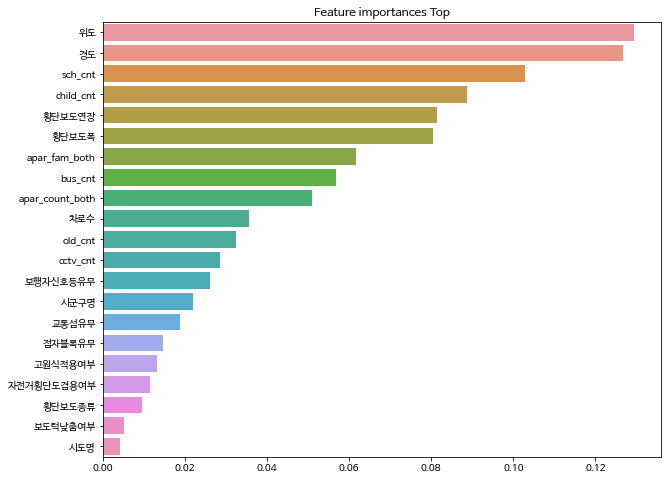

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(10, 8))
plt.title('Feature importances Top')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### **5.2.3 분류모델(위경도 제외)**

#### **5.2.3.1 전처리**

In [ ]:
def tra_cnt_process():
  df_all = pd.read_csv('횡단보도_피처_count/df_final.csv') # df_fianl -> 최종 제출 파일 : '횡단보도별 주위 시설 결함.csv'

  df_acc = df_all.copy()
  df_acc['사고다발'] = 0
  df_acc.loc[(df_acc['acc_cnt']<=9), '사고다발'] = 0
  df_acc.loc[(df_acc['acc_cnt']>9), '사고다발'] = 1

  df = df_acc.drop(df_all.columns[[3,15,16,17,18,22,23,24,25]], axis=1)
  df = apar_cnt_both(df)
  
  lst = ['횡단보도연장','횡단보도폭','차로수']

  for col in lst: 
    df[col] = np.log1p(df[col])
  
  df = df.astype({'횡단보도종류':'object'})
  df = df.drop(['횡단보도관리번호', 'acc_cnt','소재지지번주소','도로명','위도','경도'], axis=1)

  return df

#### **5.2.3.2 모델(랜덤포레스트) 성능**

In [ ]:
df = tra_cnt_process()
df_label = label_encoding(df)

X = df_label.drop('사고다발', axis=1)
y = df_label[['사고다발']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = X_train.copy()

std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)


rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print('\t정확도:', accuracy_score(y_test, y_pred))
print('\trecall:', recall_score(y_test, y_pred))
print('\tprecision:', precision_score(y_test, y_pred))
print('\tF1점수:', f1_score(y_test, y_pred))

	정확도: 0.8091158327621659
	recall: 0.8290657439446367
	precision: 0.7944297082228117
	F1점수: 0.8113782593972231


#### **5.2.3.3 하이퍼파라미터를 통해 도출된 모델의 최고 성능**

In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators = 400, 
                                max_depth = 24,
                                min_samples_leaf = 1,
                                min_samples_split = 3,
                                random_state = 42,
                                n_jobs = -1)
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('\t정확도:', accuracy_score(y_test, y_pred))
print('\trecall:', recall_score(y_test, y_pred))
print('\tprecision:', precision_score(y_test, y_pred))
print('\tF1점수:', f1_score(y_test, y_pred))

	정확도: 0.8122001370801919
	recall: 0.8359861591695502
	precision: 0.7952600394996708
	F1점수: 0.815114709851552


### **5.2.4 분류모델(위경도 제외)을 통해 도출된 피처 중요도**

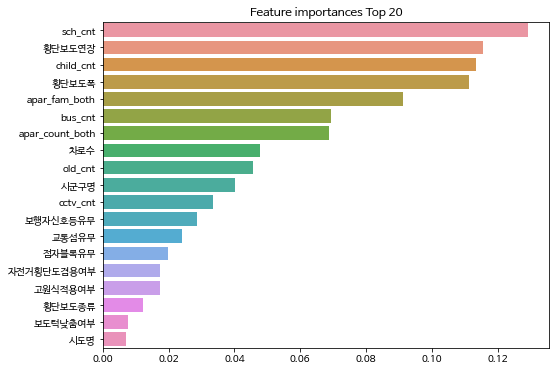

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# **6. 데이터 군집화**

## **6.1 함수정의 및 데이터 전처리** 

In [ ]:
def elbow(x):#최적 군집개수 시각화 함수
  sse = []
  for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', random_state=0)
    km.fit(x)
    sse.append(km.inertia_)
  
  plt.plot(range(1,11), sse, marker='o')
  plt.xlabel('클러스터수')
  plt.ylabel('sse')
  plt.show()

In [ ]:
df_final = pd.read_csv('횡단보도_피처_count/df_final.csv') # df_fianl -> 최종 제출 파일 : '횡단보도별 주위 시설 결함.csv'
df_final = apar_cnt_both(df_final)

def cluster_preprocessing(data):
  df = data.copy()
  df = df[['acc_cnt','sch_cnt','child_cnt','old_cnt','횡단보도폭','횡단보도연장','차로수','apar_fam_both','cctv_cnt','bus_cnt']]
  standard_scaler = StandardScaler()
  mall_scaled_df = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns) # scaled된 데이터

  return mall_scaled_df

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

def clustering(data, num):
  df = data.copy()
  df_region = df[['시도명','시군구명','도로명','소재지지번주소','횡단보도관리번호','위도','경도']]
  df = df[['acc_cnt','sch_cnt','child_cnt','old_cnt','apar_fam_both','cctv_cnt','bus_cnt','횡단보도폭','횡단보도연장','차로수']]

  df = df.rename(columns={'acc_cnt':'신고수','sch_cnt':'학교수','child_cnt':'어린이시설수','old_cnt':'노인시설수','apar_fam_both':'아파트세대수','cctv_cnt':'cctv수','bus_cnt':'버스정류장수'})
 
  standard_scaler = StandardScaler()
  mall_scaled_df = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns) # scaled된 데이터

  model = KMeans(n_clusters=num,algorithm='auto', random_state=42)
  model.fit(mall_scaled_df)
  predict = pd.DataFrame(model.predict(mall_scaled_df))
  predict.columns=['predict']

  df_region = df_region.reset_index(drop=True)
  df = df.reset_index(drop=True)
  predict = predict.reset_index(drop=True)

  r = pd.concat([df_region, df, predict], axis=1)
  return r

## **6.2 최적 군집개수 시각화**

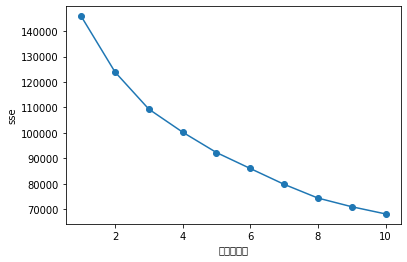

In [ ]:
df = cluster_preprocessing(df_final)
elbow(df)

## **6.3 군집화를 통해 도출된 군집별 특성**

In [ ]:
df = clustering(df_final, 3)
round(df.groupby(df['predict']).mean(),2)

,위도,경도,신고수,학교수,어린이시설수,노인시설수,아파트세대수,cctv수,버스정류장수,횡단보도폭,횡단보도연장,차로수
predict,,,,,,,,,,,,
0,36.49,127.30,49.04,5.46,5.08,0.95,5569.82,0.35,1.97,8.72,17.82,5.80
1,36.51,127.18,8.36,2.46,2.30,0.61,1746.57,0.08,0.84,4.85,8.72,2.11
2,36.44,127.33,22.89,7.82,7.70,1.62,5807.56,0.37,1.59,5.02,8.22,2.06


In [ ]:
df = clustering(df_final, 8)
round(df.groupby(df['predict']).mean(),2)

,위도,경도,신고수,학교수,어린이시설수,노인시설수,아파트세대수,cctv수,버스정류장수,횡단보도폭,횡단보도연장,차로수
predict,,,,,,,,,,,,
0,36.75,127.17,38.89,6.19,5.69,0.40,2656.46,0.36,1.88,17.70,6.87,4.77
1,36.50,127.16,6.36,1.71,1.46,0.63,1530.48,0.01,0.68,4.70,8.47,2.00
2,36.46,127.31,163.13,6.69,7.23,1.50,4996.39,0.51,2.34,6.73,14.98,4.56
3,36.50,127.30,16.58,6.52,6.36,0.64,2925.06,0.00,1.49,4.96,7.66,2.06
4,36.53,127.26,20.17,5.64,4.87,0.82,2931.47,1.26,1.50,5.17,8.62,2.36
5,36.35,127.37,23.88,8.12,4.17,0.07,19066.23,0.17,1.59,5.27,10.42,2.93
6,36.34,127.37,20.33,8.43,11.62,4.51,3508.74,0.24,1.53,5.15,10.20,2.33
7,36.47,127.29,22.22,3.70,3.88,0.91,3293.68,0.15,1.66,6.94,21.17,5.85


In [ ]:
round(df.groupby(df['predict']).median(),2)

,위도,경도,신고수,학교수,어린이시설수,노인시설수,아파트세대수,cctv수,버스정류장수,횡단보도폭,횡단보도연장,차로수
predict,,,,,,,,,,,,
0,36.80,127.14,21.0,7.0,5.0,0.0,1987.5,0.0,2.0,16.17,6.88,5.0
1,36.38,127.30,2.0,1.0,1.0,0.0,446.0,0.0,0.0,4.10,7.40,2.0
2,36.35,127.38,153.0,7.0,6.0,1.0,3014.0,0.0,2.0,6.20,12.80,5.0
3,36.36,127.35,10.0,7.0,6.0,0.0,2453.0,0.0,2.0,4.10,7.00,2.0
4,36.39,127.33,14.0,6.0,4.0,0.0,1710.0,1.0,2.0,4.60,7.04,2.0
5,36.36,127.38,17.0,8.0,4.0,0.0,22110.0,0.0,2.0,5.00,7.70,2.0
6,36.34,127.42,14.0,9.0,10.0,4.0,2536.0,0.0,2.0,4.60,8.50,2.0
7,36.36,127.35,13.0,3.0,3.0,0.0,2282.0,0.0,2.0,6.60,20.20,6.0


## **6.4 우선 선정 지표를 통한 결과 도출**

### **6.4.1 우선 선정 지표 계산**
- 'clustering_result' 파일은 최종 제출 파일에서 '클러스터링 결과.csv' 파일과 동일한 파일이다

In [ ]:
df2 = pd.read_csv('clustering_result.csv') # clustering_result -> 최종 제출 파일 : '클러스터링 결과.csv'
df_clus = df2.copy()
df_clus = df_clus[df_clus['predict']==2]

In [ ]:
def best_region(data, region):
  df = data.copy()
  #df = df[df['predict']==2]
  df = df[df['시군구명']==region]
  df = df.reset_index(drop=True)

  df_col = df[['학교수','어린이시설수','노인시설수']]
  standard_scaler = StandardScaler()
  scaled_df_col = pd.DataFrame(standard_scaler.fit_transform(df_col), columns=df_col.columns) # scaled된 데이터
  df['종합가중치'] = scaled_df_col['학교수']*0.125191 + scaled_df_col['어린이시설수']*0.111548 + scaled_df_col['노인시설수']*0.045236
  df['우선선정지표'] = df['종합가중치'] * df['신고수']

  df = df[df['종합가중치']>0].sort_values('우선선정지표', ascending=False)
  return df

### **6.4.1 우선 선정 지표를 통한 지역별 대상 횡단보도 정렬**
- 선정된 클러스터 전체에 대해 돌린 것이 아닌 각 지역을 나누어 '우선선정지표'를 구하고 정렬한 결과는 다음과 같다.

#### **6.4.1.1 대전광역시 중구 우선 입지 횡단보도 정렬**

In [ ]:
df_gu = best_region(df_clus,'중구')
df_gu.iloc[:, [3, 4, 5, 6, 7, 8,9,10,11,18,19]]

,소재지지번주소,횡단보도관리번호,위도,경도,신고수,학교수,어린이시설수,노인시설수,아파트세대수,종합가중치,우선선정지표
8,대전광역시중구오류동118-4,624,36.323560,127.404209,72,15,28,6,3193,0.527726,37.996302
410,대전광역시중구중촌동1-144,7107,36.334531,127.413213,108,14,21,5,5236,0.295476,31.911398
411,대전광역시중구중촌동418-1,7108,36.334740,127.413141,108,14,21,5,5236,0.295476,31.911398
4,대전광역시중구오류동196-1,620,36.323675,127.404335,64,15,28,5,3193,0.494878,31.672178
412,대전광역시중구중촌동156-35,7109,36.334717,127.413418,98,14,21,5,5236,0.295476,28.956639
...,...,...,...,...,...,...,...,...,...,...,...
392,대전광역시중구목동143-26,6631,36.331890,127.405886,0,13,25,5,5134,0.340864,0.000000
317,대전광역시중구용두동168,4976,36.327132,127.410377,0,14,16,5,1609,0.184208,0.000000
618,대전광역시중구목동339-183,9321,36.330013,127.415325,0,15,16,5,5134,0.227834,0.000000
627,대전광역시중구선화동259-15,9330,36.329699,127.415521,0,15,16,5,2616,0.227834,0.000000


#### **6.4.1.2 대전광역시 동구 우선 입지 횡단보도 정렬**

In [ ]:
df_gu = best_region(df_clus,'동구')
df_gu.iloc[:, [3, 4, 5, 6, 7, 8,9,10,11,18,19]]

,소재지지번주소,횡단보도관리번호,위도,경도,신고수,학교수,어린이시설수,노인시설수,아파트세대수,종합가중치,우선선정지표
139,대전광역시동구가양동159,2725,36.333956,127.445573,95,11,7,7,1954,0.227529,21.615212
134,대전광역시동구자양동407-1,2720,36.333723,127.445597,91,11,7,7,1981,0.227529,20.705098
178,대전광역시동구가양동630,2783,36.345523,127.445932,114,9,7,8,2783,0.154008,17.556888
174,대전광역시동구가양동630,2779,36.345355,127.445882,112,9,7,8,1981,0.154008,17.248872
176,대전광역시동구가양동630,2781,36.345429,127.446072,110,9,7,8,1981,0.154008,16.940857
...,...,...,...,...,...,...,...,...,...,...,...
236,대전광역시동구판암동841,5783,36.318186,127.459457,10,7,8,3,9326,0.003996,0.039960
341,대전광역시동구성남동80-28,8390,36.338465,127.434754,7,12,4,4,2536,0.005706,0.039945
238,대전광역시동구판암동839,5785,36.318376,127.459511,9,7,8,3,9326,0.003996,0.035964
340,대전광역시동구성남동143-9,8388,36.338431,127.434618,5,12,4,4,2536,0.005706,0.028532


#### **6.4.1.3 대전광역시 유성구 우선 입지 횡단보도 정렬**

In [ ]:
df_gu = best_region(df_clus,'유성구')
df_gu.iloc[:, [3, 4, 5, 6, 7, 8,9,10,11,18,19]]

,소재지지번주소,횡단보도관리번호,위도,경도,신고수,학교수,어린이시설수,노인시설수,아파트세대수,종합가중치,우선선정지표
35,대전광역시유성구봉명동498,3634,36.348431,127.340003,105,8,11,5,9247,0.169009,17.745895
36,대전광역시유성구봉명동1058-1,3635,36.348688,127.339971,92,8,11,5,9247,0.169009,15.548784
37,대전광역시유성구봉명동489,3636,36.348288,127.339990,89,8,11,5,9247,0.169009,15.041759
142,대전광역시유성구장대동466-2,9218,36.354072,127.336705,60,9,9,6,1710,0.185367,11.122044
127,대전광역시유성구장대동534,9201,36.354547,127.336541,47,9,9,6,1710,0.185367,8.712268
...,...,...,...,...,...,...,...,...,...,...,...
59,대전광역시유성구봉명동1067,3735,36.346690,127.341625,10,8,9,3,9247,0.004243,0.042428
58,대전광역시유성구봉명동1066,3734,36.347469,127.341715,5,8,9,3,9247,0.004243,0.021214
57,대전광역시유성구봉명동1067,3733,36.347553,127.341626,5,8,9,3,9247,0.004243,0.021214
74,대전광역시유성구봉명동1067,3764,36.347163,127.341624,4,8,9,3,9247,0.004243,0.016971


#### **6.4.1.4 대전광역시 대덕구 우선 입지 횡단보도 정렬**

In [ ]:
df_gu = best_region(df_clus,'대덕구')
df_gu.iloc[:, [3, 4, 5, 6, 7, 8,9,10,11,18,19]]

,소재지지번주소,횡단보도관리번호,위도,경도,신고수,학교수,어린이시설수,노인시설수,아파트세대수,종합가중치,우선선정지표
28,대전광역시대덕구송촌동520,247,36.357784,127.445597,74,5,13,3,6320,0.130797,9.679004
30,대전광역시대덕구송촌동520,249,36.357557,127.446029,47,5,13,3,6320,0.130797,6.147475
78,대전광역시대덕구석봉동340,1517,36.443837,127.425567,42,6,9,4,4444,0.135730,5.700644
77,대전광역시대덕구석봉동336,1516,36.443951,127.425757,37,6,9,4,4444,0.135730,5.021996
56,대전광역시대덕구송촌동568,594,36.357122,127.445129,48,5,12,3,6320,0.085563,4.107007
...,...,...,...,...,...,...,...,...,...,...,...
76,대전광역시대덕구석봉동294-12,1515,36.442522,127.428875,8,5,8,4,4444,0.017714,0.141711
71,대전광역시대덕구석봉동748,1473,36.447384,127.425765,27,7,7,3,4444,0.004951,0.133684
24,대전광역시대덕구비래동532,220,36.359533,127.452207,10,4,12,3,2157,0.012782,0.127816
70,대전광역시대덕구석봉동748,1471,36.447389,127.425950,25,7,7,3,4444,0.004951,0.123782


#### **6.4.1.5 충청남도 보령시 우선 입지 횡단보도 정렬**

In [ ]:
df_gu = best_region(df_clus,'보령시')
df_gu.iloc[:, [3, 4, 5, 6, 7, 8,9,10,11,18,19]]

,소재지지번주소,횡단보도관리번호,위도,경도,신고수,학교수,어린이시설수,노인시설수,아파트세대수,종합가중치,우선선정지표
21,충청남도보령시대천동618-403,NaN,36.349108,126.599877,30,5,5,5,1595,0.163341,4.900240
20,충청남도보령시대천동618-355,NaN,36.349198,126.599853,29,5,5,5,1595,0.163341,4.736899
29,충청남도보령시대천동618-370,NaN,36.349599,126.597966,70,5,3,6,1595,0.062400,4.367999
30,충청남도보령시대천동618-263,NaN,36.349742,126.598210,61,5,3,6,1595,0.062400,3.806399
1,충청남도보령시동대동1954,NaN,36.345886,126.601676,81,4,5,5,4860,0.046719,3.784231
0,충청남도보령시명천동1021,NaN,36.345759,126.601670,80,4,5,5,7338,0.046719,3.737512
16,충청남도보령시대천동618-9,NaN,36.350825,126.600958,19,5,6,4,1595,0.185286,3.520428
22,충청남도보령시대천동618-453,NaN,36.348682,126.599512,20,5,4,6,1595,0.141397,2.827939
7,충청남도보령시동대동1210,NaN,36.350220,126.601972,15,5,6,4,4860,0.185286,2.779285
6,충청남도보령시동대동1256,NaN,36.349983,126.602069,15,5,6,4,4860,0.185286,2.779285


#### **6.4.1.6 충청남도 천안시 우선 입지 횡단보도 정렬**

In [ ]:
df_gu = best_region(df_clus,'천안시')
df_gu.iloc[:, [3, 4, 5, 6, 7, 8,9,10,11,18,19]]

,소재지지번주소,횡단보도관리번호,위도,경도,신고수,학교수,어린이시설수,노인시설수,아파트세대수,종합가중치,우선선정지표
3,충청남도천안시서북구쌍용동257-21,896022,36.804507,127.127482,27,11,14,2,0,0.329613,8.899545
10,충청남도천안시서북구쌍용동203-29,307014,36.798407,127.130323,53,9,14,2,2275,0.066659,3.532932
4,충청남도천안시서북구쌍용동1261,896021,36.804758,127.127908,14,11,13,2,0,0.180550,2.527707
6,충청남도천안시서북구쌍용동1268,896013,36.803394,127.127735,51,10,13,2,0,0.049074,2.502756
1,충청남도천안시동남구쌍용동559,897004,36.801773,127.131869,29,9,14,2,2275,0.066659,1.933114
5,충청남도천안시서북구쌍용동257-21,896016,36.803949,127.127443,31,10,13,2,3014,0.049074,1.521283
0,충청남도천안시서북구쌍용동1257,897005,36.801897,127.131553,21,9,14,2,0,0.066659,1.399841
14,충청남도천안시서북구쌍용동310-35,253202,36.808944,127.127737,1,10,13,2,0,0.049074,0.049074
